# Chapter 4: Unigrams and n-grams, and resampling the training data

In [1]:
import configparser
from getpass import getuser
config = configparser.ConfigParser()
config.read(f"../config/{getuser()}.ini")
if len(config.sections()) == 0:
    config.read("../config/default.ini")
DATA_PATH = config["Data"]["path"]

import os
import pandas as pd
df = pd.read_pickle(os.path.join(DATA_PATH, "df.pkl"))
print(df.shape)

(5920, 11)


## Data Cleaning

In [2]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

FEATURE_NAME = "Body_Text"

sw = stopwords.words("english")
wnl = WordNetLemmatizer()
df[FEATURE_NAME] = df[FEATURE_NAME].apply(lambda x: " ".join([wnl.lemmatize(w.lower()) for w in x.split() if w not in sw]))
df.dropna(subset=[FEATURE_NAME], inplace=True)
df = df[df[FEATURE_NAME] != ""]
display(df.head())

X = df[FEATURE_NAME]
y = df["Sentiment"]

,Title,URL,Time_Published,Body_Text,Company,Symbol,Positive,Negative,Polarity,News_Id,Sentiment
4883,Charles Li: HK Stocks Resilient; Recent Turnov...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-14 15:10:00,hkex ex-ceo charles li found hard predict unit...,HKEX,00388.HK,31,13,0.409091,NOW.1069199,1
5685,A-LIVING (03319.HK) Sees FY20 NP Up At Least 4...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-25 08:19:00,"a-living issued positive profit alert, expecti...",A-LIVING,03319.HK,71,27,0.448980,NOW.1071381,1
4708,US WeChat Users File Lawsuit Against TENCENT f...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-13 08:50:00,u.s. ngo citizen power initiative china six we...,U.S. NGO Citizen Power Initiatives for China a...,00700.HK,46,44,0.022222,NOW.1068710,0
5228,Carrie Lam: Jobless Claim Hardly Feasible in H...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-19 10:24:00,in response street proposal unemployment benef...,,,4,16,-0.600000,NOW.1070189,-1
3574,ESPRIT HOLDINGS (00330.HK) Non-exec. Chair Ray...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-28 00:26:00,esprit holding announced resignation raymond o...,ESPRIT HOLDINGS,00330.HK,19,15,0.117647,NOW.1065294,0


## Fitting and evaluating models for unigram to trigram

### SVM

1-gram:
	Max accuracy: 0.6662162162162162 
	C=5


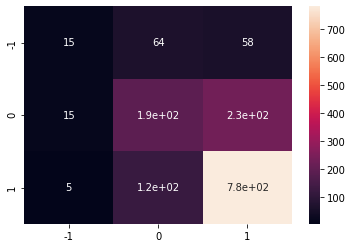

2-gram:
	Max accuracy: 0.6506756756756756 
	C=13


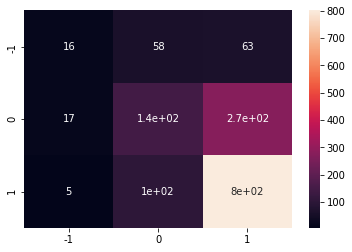

3-gram:
	Max accuracy: 0.6364864864864865 
	C=41


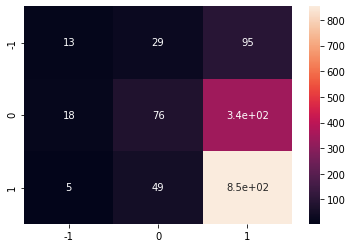

In [3]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for n in [1, 2, 3]:
    max_accuracy = max_accuracy_c = max_accuracy_confusion_matrix = 0
    for c in np.arange(0.005, 1, 0.2).tolist() + np.arange(1, 50, 4).tolist():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
        count_vectorizer = CountVectorizer(ngram_range=(n, n))
        count_vectorizer.fit(X_train)
        X_train = count_vectorizer.transform(X_train)
        X_test = count_vectorizer.transform(X_test)
        
        model = SVC(C=c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_c = c
            max_accuracy_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(f"{n}-gram:")
    print("\tMax accuracy:", max_accuracy, f"\n\tC={max_accuracy_c}")
    sns.heatmap(max_accuracy_confusion_matrix, annot=True, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.show()

Still far from satisfactory (although much better than the lexicon based methods)\
The prediction is skewed towards the positive class, probably because the training data is imbalanced towards the positive class\
Let's train the model again after undersampling / oversampling the training data

Acknowledgements:\
Thanks [Judy](https://medium.com/@judytraj007) for the [tutorial](https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36)

1-gram:
	Max accuracy: 0.5851351351351352 
	C=0.405


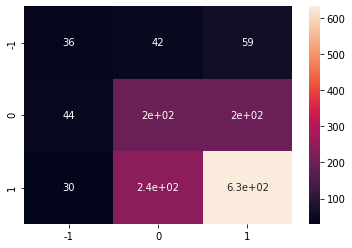

2-gram:
	Max accuracy: 0.6108108108108108 
	C=49


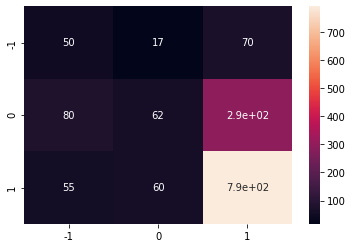

3-gram:
	Max accuracy: 0.2993243243243243 
	C=0.805


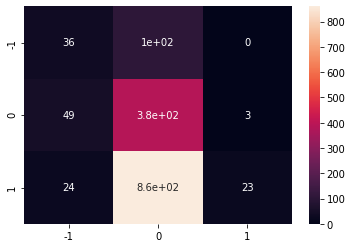

In [4]:
from sklearn.utils import resample

for n in [1, 2, 3]:
    max_accuracy = max_accuracy_c = max_accuracy_confusion_matrix = 0
    for c in np.arange(0.005, 1, 0.2).tolist() + np.arange(1, 50, 4).tolist():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
        
        # Undersampling the training data
        train = pd.concat([X_train, y_train], axis=1)
        train_positive = train[train["Sentiment"] == 1]
        train_neutral = train[train["Sentiment"] == 0]
        train_negative = train[train["Sentiment"] == -1]
        train_positive_resampled = resample(train_positive, n_samples=len(train_negative), random_state=70)
        train_neutral_resampled = resample(train_neutral, n_samples=len(train_negative), random_state=70)
        train_resampled = pd.concat([train_positive_resampled, train_neutral_resampled, train_negative])
        X_train = train_resampled[FEATURE_NAME]
        y_train = train_resampled["Sentiment"]

        count_vectorizer = CountVectorizer(ngram_range=(n, n))
        count_vectorizer.fit(X_train)
        X_train = count_vectorizer.transform(X_train)
        X_test = count_vectorizer.transform(X_test)

        model = SVC(C=c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_c = c
            max_accuracy_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(f"{n}-gram:")
    print("\tMax accuracy:", max_accuracy, f"\n\tC={max_accuracy_c}")
    sns.heatmap(max_accuracy_confusion_matrix, annot=True, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.show()

1-gram:
	Max accuracy: 0.6560810810810811 
	C=5


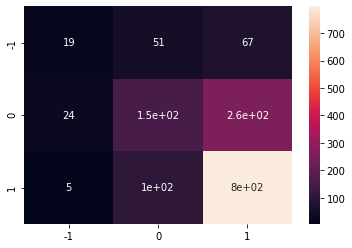

2-gram:
	Max accuracy: 0.6493243243243243 
	C=1


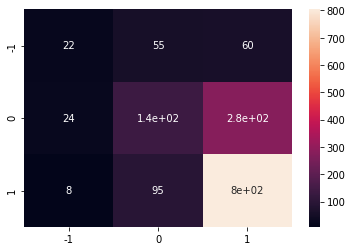

3-gram:
	Max accuracy: 0.6398648648648648 
	C=0.805


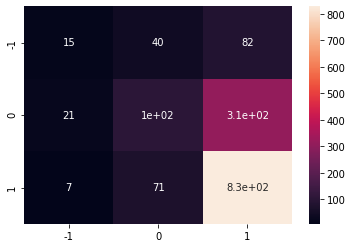

In [5]:
from sklearn.utils import resample

for n in [1, 2, 3]:
    max_accuracy = max_accuracy_c = max_accuracy_confusion_matrix = 0
    for c in np.arange(0.005, 1, 0.2).tolist() + np.arange(1, 50, 4).tolist():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
        
        # Oversampling the training data
        train = pd.concat([X_train, y_train], axis=1)
        train_positive = train[train["Sentiment"] == 1]
        train_neutral = train[train["Sentiment"] == 0]
        train_negative = train[train["Sentiment"] == -1]
        train_neutral_resampled = resample(train_neutral, n_samples=len(train_positive), random_state=70)
        train_negative_resampled = resample(train_negative, n_samples=len(train_positive), random_state=70)
        train_resampled = pd.concat([train_positive, train_neutral_resampled, train_negative_resampled])
        X_train = train_resampled[FEATURE_NAME]
        y_train = train_resampled["Sentiment"]

        count_vectorizer = CountVectorizer(ngram_range=(n, n))
        count_vectorizer.fit(X_train)
        X_train = count_vectorizer.transform(X_train)
        X_test = count_vectorizer.transform(X_test)

        model = SVC(C=c)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_c = c
            max_accuracy_confusion_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    print(f"{n}-gram:")
    print("\tMax accuracy:", max_accuracy, f"\n\tC={max_accuracy_c}")
    sns.heatmap(max_accuracy_confusion_matrix, annot=True, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.show()

Undersampling / oversampling do not help in this case, maybe more training data are needed